# **Cigarettes Counting Simple Project with Yolo**

## **Import Library**

In [73]:
import os
import cv2
import albumentations as A

from ultralytics import YOLO
from IPython.display import Image
import pandas as pd

## **Augmentation Image**

In [76]:
img_dir = 'data/images/train/'
label_dir = 'data/labels/train/'

aug_img_dir = 'data/augmented/images/train/'
aug_label_dir = 'data/augmented/labels/train/'

os.makedirs(aug_img_dir, exist_ok=True)
os.makedirs(aug_label_dir, exist_ok=True)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.Blur(p=0.3),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

for filename in os.listdir(img_dir):
    if not filename.endswith(('.jpg', '.png')): continue

    img_path = os.path.join(img_dir, filename)
    label_path = os.path.join(label_dir, filename.replace('.jpg', '.txt').replace('.png', '.txt'))

    if not os.path.exists(label_path):
        print(f"Label doesn't exist for: {filename}, skipping")
        continue

    image = cv2.imread(img_path)
    h, w = image.shape[:2]

    bboxes = []
    class_labels = []

    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            cls = int(parts[0])
            bbox = list(map(float, parts[1:]))
            bboxes.append(bbox)
            class_labels.append(cls)

    for i in range(5):
        augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        aug_img = augmented['image']
        aug_bboxes = augmented['bboxes']

        new_img_name = filename.replace('.png', f'_aug{i + 1}.png').replace('.jpg', f'_aug{i + 1}.jpg')
        new_label_name = new_img_name.replace('.png', '.txt').replace('.jpg', '.txt')

        cv2.imwrite(os.path.join(aug_img_dir, new_img_name), aug_img)

        with open(os.path.join(aug_label_dir, new_label_name), 'w') as f:
            for bbox, cls in zip(aug_bboxes, class_labels):
                f.write(f"{cls} {' '.join([f'{v:.6f}' for v in bbox])}\n")

print("Finish augmentation..")

Finish augmentation..


## **Training Model YOLOv8**

In [77]:
model = YOLO('yolov8n.pt')
model.train(
    data='cigarettes.yaml',
    epochs=50,
    imgsz=640,
    batch=8
)

Ultralytics 8.3.140 🚀 Python-3.12.9 torch-2.7.0+cu126 CPU (Intel Core(TM) i3-1005G1 1.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cigarettes.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True

train: Scanning /home/refanzzzz/PycharmProjects/cigarettes-yolo/data/augmented/labels/train... 25 images, 0 backgrounds, 0 corrupt: 100%|██████████| 25/25 [00:00<00:00, 21321.19it/s]

train: New cache created: /home/refanzzzz/PycharmProjects/cigarettes-yolo/data/augmented/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1467.9±1192.1 MB/s, size: 122.4 KB)



/home/refanzzzz/miniconda3/envs/cigarettes-yolo/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning /home/refanzzzz/PycharmProjects/cigarettes-yolo/data/labels/train... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 33770.56it/s]

val: New cache created: /home/refanzzzz/PycharmProjects/cigarettes-yolo/data/labels/train.cache
Plotting labels to runs/detect/train/labels.jpg... 



/home/refanzzzz/miniconda3/envs/cigarettes-yolo/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.584      3.474       1.36         87        640: 100%|██████████| 4/4 [00:12<00:00,  3.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

                   all          5        214      0.121      0.846       0.16      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.371      3.269      1.261         48        640: 100%|██████████| 4/4 [00:12<00:00,  3.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

                   all          5        214      0.135      0.944      0.202      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.204       2.71      1.138         36        640: 100%|██████████| 4/4 [00:11<00:00,  2.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all          5        214      0.141      0.986       0.23      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.144      2.403      1.057        104        640: 100%|██████████| 4/4 [00:11<00:00,  2.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

                   all          5        214      0.141      0.986       0.25      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.379      2.037      1.182         94        640: 100%|██████████| 4/4 [00:12<00:00,  3.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all          5        214       0.14      0.981      0.595       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.383      1.525      1.048        190        640: 100%|██████████| 4/4 [00:12<00:00,  3.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all          5        214      0.143          1      0.916      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.301      1.265      1.059         35        640: 100%|██████████| 4/4 [00:12<00:00,  3.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all          5        214       0.87      0.659      0.885      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.252      1.326      1.046         31        640: 100%|██████████| 4/4 [00:11<00:00,  2.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

                   all          5        214      0.857      0.781      0.888      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.351      1.221      1.119         66        640: 100%|██████████| 4/4 [00:14<00:00,  3.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

                   all          5        214      0.887      0.855      0.941      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.137     0.9712      0.961         38        640: 100%|██████████| 4/4 [00:20<00:00,  5.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all          5        214      0.944      0.893      0.976      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G       1.12     0.8577     0.9676         44        640: 100%|██████████| 4/4 [00:16<00:00,  4.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

                   all          5        214      0.985      0.934      0.989      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.311      1.007      1.054         49        640: 100%|██████████| 4/4 [00:14<00:00,  3.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all          5        214      0.975      0.977      0.993      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.168      1.074      1.019        163        640: 100%|██████████| 4/4 [00:13<00:00,  3.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all          5        214      0.981      0.983      0.995      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.221      1.049       1.03         87        640: 100%|██████████| 4/4 [00:20<00:00,  5.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

                   all          5        214      0.992      0.991      0.991      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.423      3.025      1.366          7        640: 100%|██████████| 4/4 [00:21<00:00,  5.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

                   all          5        214      0.936      0.944      0.979      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.169     0.8671      1.032         63        640: 100%|██████████| 4/4 [00:16<00:00,  4.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

                   all          5        214      0.936      0.944      0.979      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.069     0.9049          1         30        640: 100%|██████████| 4/4 [00:17<00:00,  4.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

                   all          5        214      0.952      0.888      0.975      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.126     0.9275      1.043         29        640: 100%|██████████| 4/4 [00:18<00:00,  4.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all          5        214      0.971       0.93      0.989      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.144     0.9224      1.012         53        640: 100%|██████████| 4/4 [00:12<00:00,  3.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all          5        214      0.971       0.93      0.989      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.055      1.022      1.015         22        640: 100%|██████████| 4/4 [00:13<00:00,  3.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all          5        214      0.988      0.963      0.993      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.125     0.8419     0.9942        118        640: 100%|██████████| 4/4 [00:12<00:00,  3.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

                   all          5        214      0.944      0.949      0.984      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.267      1.082      1.122         23        640: 100%|██████████| 4/4 [00:15<00:00,  3.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

                   all          5        214      0.944      0.949      0.984      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.188     0.9947     0.9769        290        640: 100%|██████████| 4/4 [00:18<00:00,  4.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all          5        214      0.959      0.963       0.99      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.181      2.059      1.082          4        640: 100%|██████████| 4/4 [00:19<00:00,  4.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

                   all          5        214      0.959      0.963       0.99      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.062     0.8946      1.016        134        640: 100%|██████████| 4/4 [00:14<00:00,  3.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]

                   all          5        214      0.985          1      0.994       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.087     0.8404     0.9646        102        640: 100%|██████████| 4/4 [00:17<00:00,  4.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all          5        214      0.985          1      0.994       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G       1.11     0.8523      1.041         42        640: 100%|██████████| 4/4 [00:14<00:00,  3.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

                   all          5        214      0.979          1      0.995      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.116      1.111      1.056         21        640: 100%|██████████| 4/4 [00:13<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

                   all          5        214      0.979          1      0.995      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.051     0.8257     0.9847        119        640: 100%|██████████| 4/4 [00:14<00:00,  3.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

                   all          5        214      0.981      0.995      0.995      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G     0.9848       0.76     0.9687         52        640: 100%|██████████| 4/4 [00:14<00:00,  3.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all          5        214      0.981      0.995      0.995      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.029     0.7496     0.9866         33        640: 100%|██████████| 4/4 [00:11<00:00,  2.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all          5        214      0.981       0.99      0.994      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G     0.9732      1.291     0.9676         10        640: 100%|██████████| 4/4 [00:14<00:00,  3.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

                   all          5        214      0.981       0.99      0.994      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G     0.9969     0.7576     0.9982         36        640: 100%|██████████| 4/4 [00:15<00:00,  3.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]

                   all          5        214       0.98      0.986      0.994      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G     0.9931     0.7108     0.9716         86        640: 100%|██████████| 4/4 [00:19<00:00,  4.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all          5        214       0.98      0.986      0.994      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      1.145     0.7575      1.062         54        640: 100%|██████████| 4/4 [00:21<00:00,  5.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

                   all          5        214      0.959      0.981      0.991      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G      1.005     0.8075      1.005         36        640: 100%|██████████| 4/4 [00:15<00:00,  3.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

                   all          5        214      0.959      0.981      0.991      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G     0.9129     0.7045      0.958        117        640: 100%|██████████| 4/4 [00:13<00:00,  3.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all          5        214      0.977      0.999      0.994      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G     0.9356     0.7042     0.9664         98        640: 100%|██████████| 4/4 [00:11<00:00,  2.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

                   all          5        214      0.977      0.999      0.994      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.9531       0.71     0.9377         57        640: 100%|██████████| 4/4 [00:22<00:00,  5.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

                   all          5        214      0.995          1      0.995      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.9862      1.451      1.003          7        640: 100%|██████████| 4/4 [00:19<00:00,  4.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all          5        214      0.995          1      0.995      0.746


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/refanzzzz/miniconda3/envs/cigarettes-yolo/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
      41/50         0G     0.9456      0.761     0.9712        100        640: 100%|██████████| 4/4 [00:12<00:00,  3.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

                   all          5        214      0.994          1      0.995      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.9239      1.674     0.9696          6        640: 100%|██████████| 4/4 [00:13<00:00,  3.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all          5        214      0.994          1      0.995      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G      0.873     0.7056     0.9601         53        640: 100%|██████████| 4/4 [00:12<00:00,  3.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all          5        214      0.993          1      0.995      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G     0.9411     0.8378     0.9794         15        640: 100%|██████████| 4/4 [00:15<00:00,  3.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all          5        214      0.993          1      0.995      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G      1.088      2.113      1.002          6        640: 100%|██████████| 4/4 [00:14<00:00,  3.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all          5        214      0.992          1      0.995      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.9035     0.7236      0.976         47        640: 100%|██████████| 4/4 [00:14<00:00,  3.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

                   all          5        214      0.992          1      0.995      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.9074     0.7278     0.9786         54        640: 100%|██████████| 4/4 [00:12<00:00,  3.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

                   all          5        214      0.992          1      0.995       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.8923     0.7654     0.9351        112        640: 100%|██████████| 4/4 [00:12<00:00,  3.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

                   all          5        214      0.992          1      0.995       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.8457     0.7904     0.9238         15        640: 100%|██████████| 4/4 [00:10<00:00,  2.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

                   all          5        214      0.992          1      0.995      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G      1.025      0.755     0.9646         61        640: 100%|██████████| 4/4 [00:10<00:00,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

                   all          5        214      0.992          1      0.995      0.748



50 epochs completed in 0.229 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.140 🚀 Python-3.12.9 torch-2.7.0+cu126 CPU (Intel Core(TM) i3-1005G1 1.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


                   all          5        214      0.994          1      0.995      0.755
Speed: 2.0ms preprocess, 123.1ms inference, 0.0ms loss, 8.0ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x76e04b8d00b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

## **Evaluating Model**

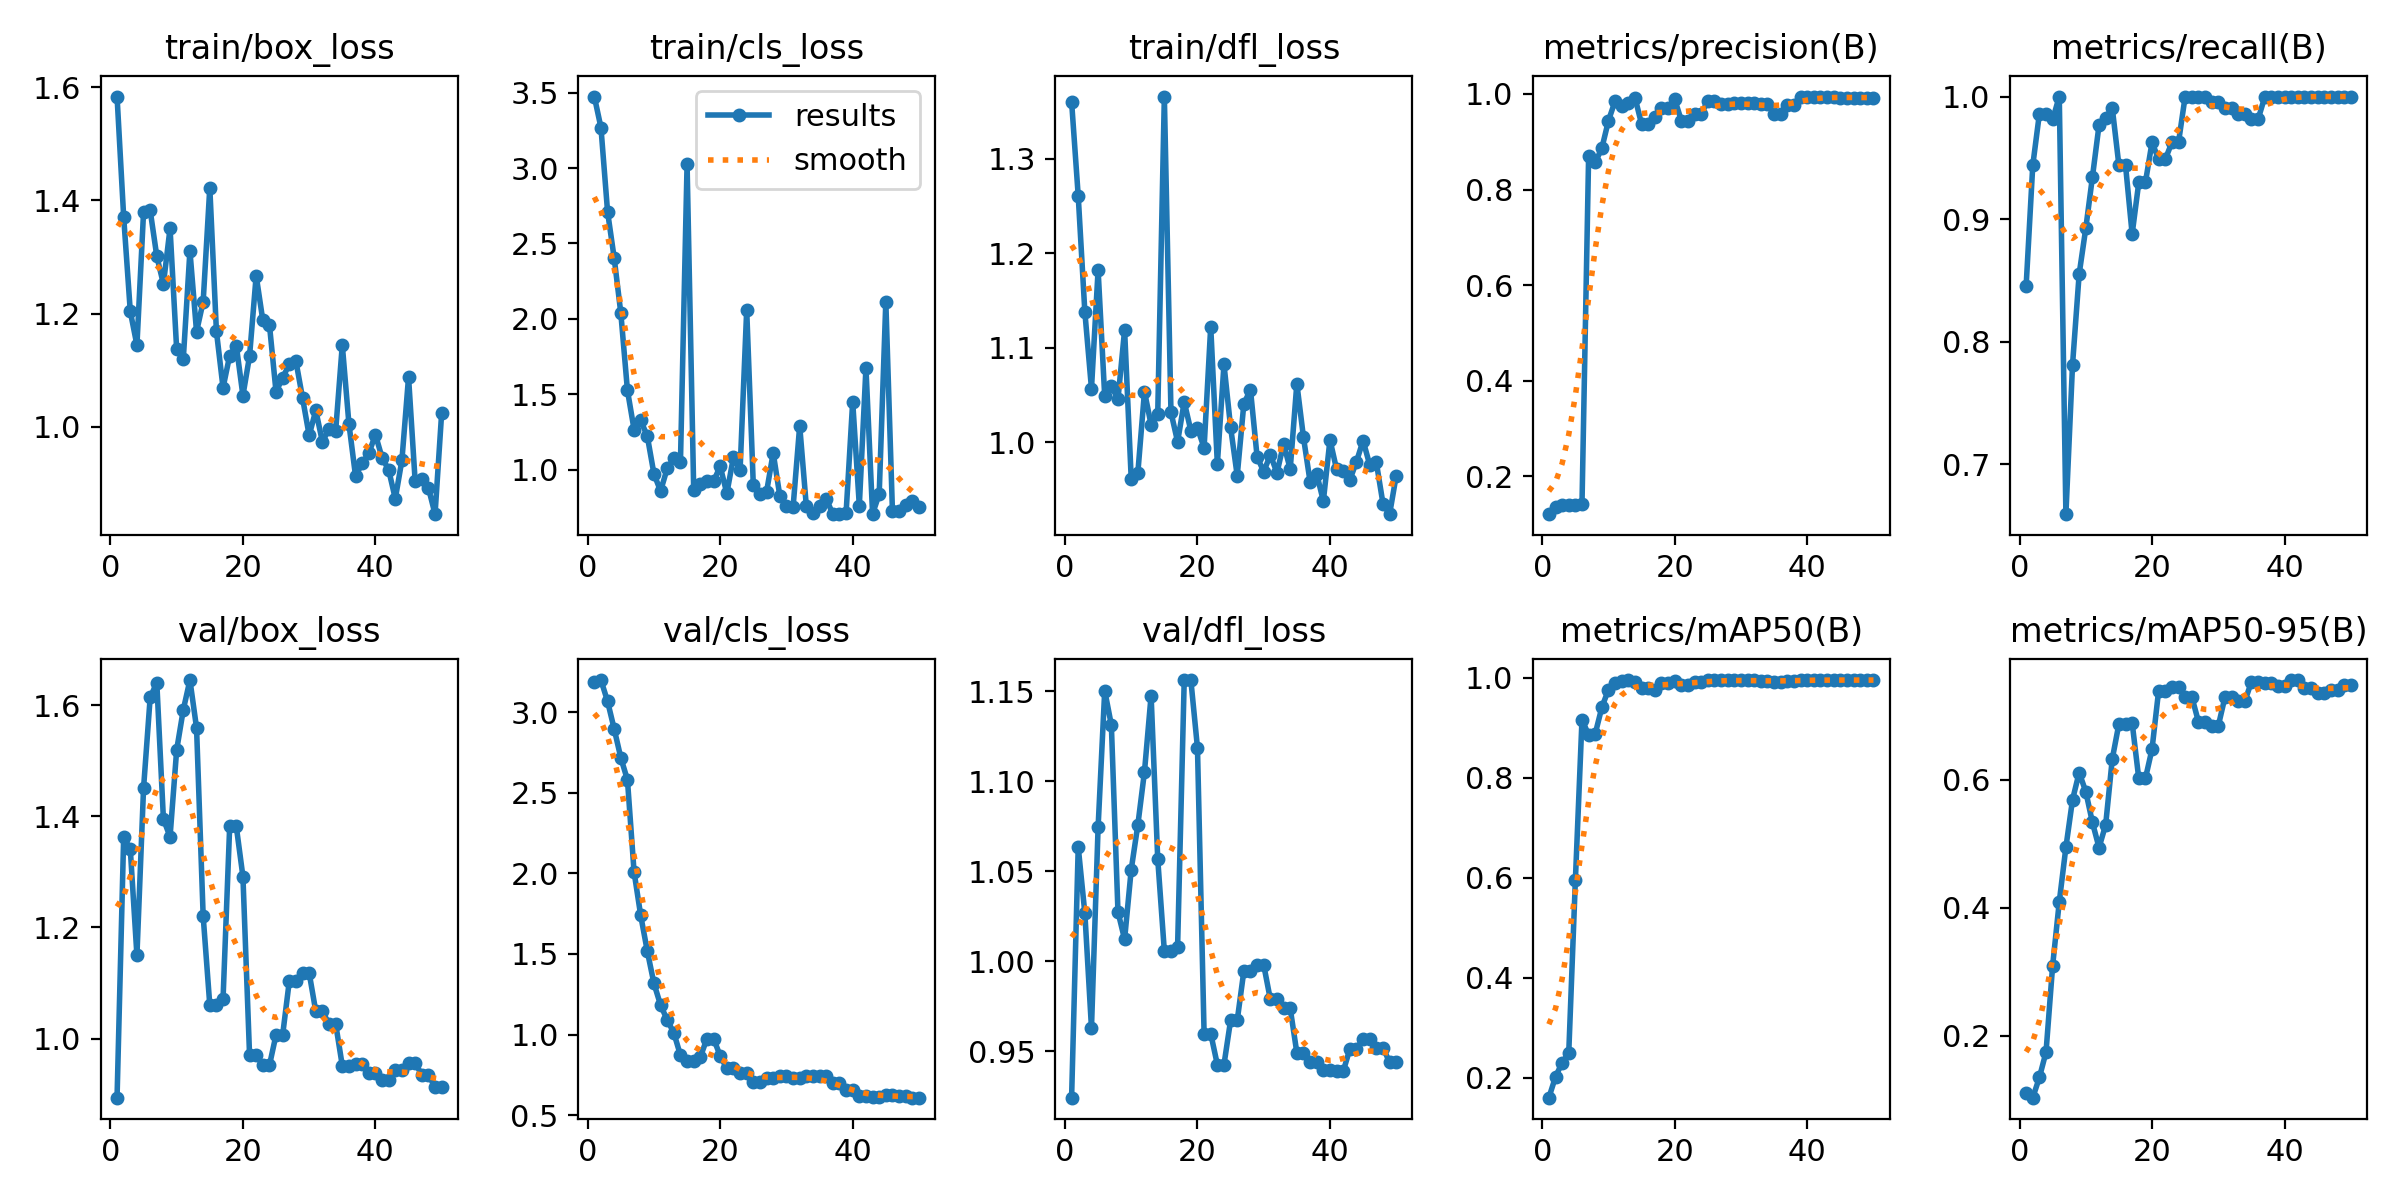

In [78]:
Image('runs/detect/train/results.png')

In [79]:
metric_df = pd.read_csv('runs/detect/train/results.csv')
metric_df

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,13.2160,1.58366,3.47410,1.36035,0.12067,0.84579,0.16017,0.11076,0.89360,3.18933,0.92425,0.000060,0.000060,0.000060
1,2,26.6701,1.37108,3.26852,1.26060,0.13467,0.94393,0.20172,0.10349,1.36290,3.20097,1.06342,0.000137,0.000137,0.000137
2,3,39.0819,1.20388,2.70998,1.13789,0.14067,0.98598,0.23024,0.13507,1.34047,3.06853,1.02664,0.000211,0.000211,0.000211
3,4,52.1287,1.14433,2.40262,1.05671,0.14067,0.98598,0.24960,0.17467,1.14957,2.89706,0.96292,0.000282,0.000282,0.000282
4,5,65.9446,1.37915,2.03735,1.18222,0.14000,0.98131,0.59474,0.30977,1.45042,2.71834,1.07441,0.000350,0.000350,0.000350
5,6,79.3090,1.38260,1.52540,1.04842,0.14267,1.00000,0.91609,0.40921,1.61371,2.58104,1.15024,0.000414,0.000414,0.000414
6,7,93.7005,1.30137,1.26536,1.05938,0.87046,0.65938,0.88516,0.49431,1.64020,2.00934,1.13112,0.000476,0.000476,0.000476
7,8,106.8960,1.25249,1.32622,1.04559,0.85653,0.78116,0.88782,0.56845,1.39471,1.73943,1.02735,0.000534,0.000534,0.000534
8,9,123.0990,1.35089,1.22125,1.11876,0.88675,0.85514,0.94059,0.61097,1.36303,1.51729,1.01217,0.000589,0.000589,0.000589
9,10,145.4840,1.13668,0.97120,0.96097,0.94430,0.89252,0.97603,0.58131,1.51937,1.31681,1.05087,0.000641,0.000641,0.000641


## **Testing Model**

## **Testing 1**

In [95]:
model = YOLO('runs/detect/train/weights/best.pt')
image_test = 'data/testing/rokok-test-1.jpeg'

results = model.predict(image_test, save=True)


image 1/1 /home/refanzzzz/PycharmProjects/cigarettes-yolo/data/testing/rokok-test-1.jpeg: 480x640 293 cigarettes, 120.5ms
Speed: 2.9ms preprocess, 120.5ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict3


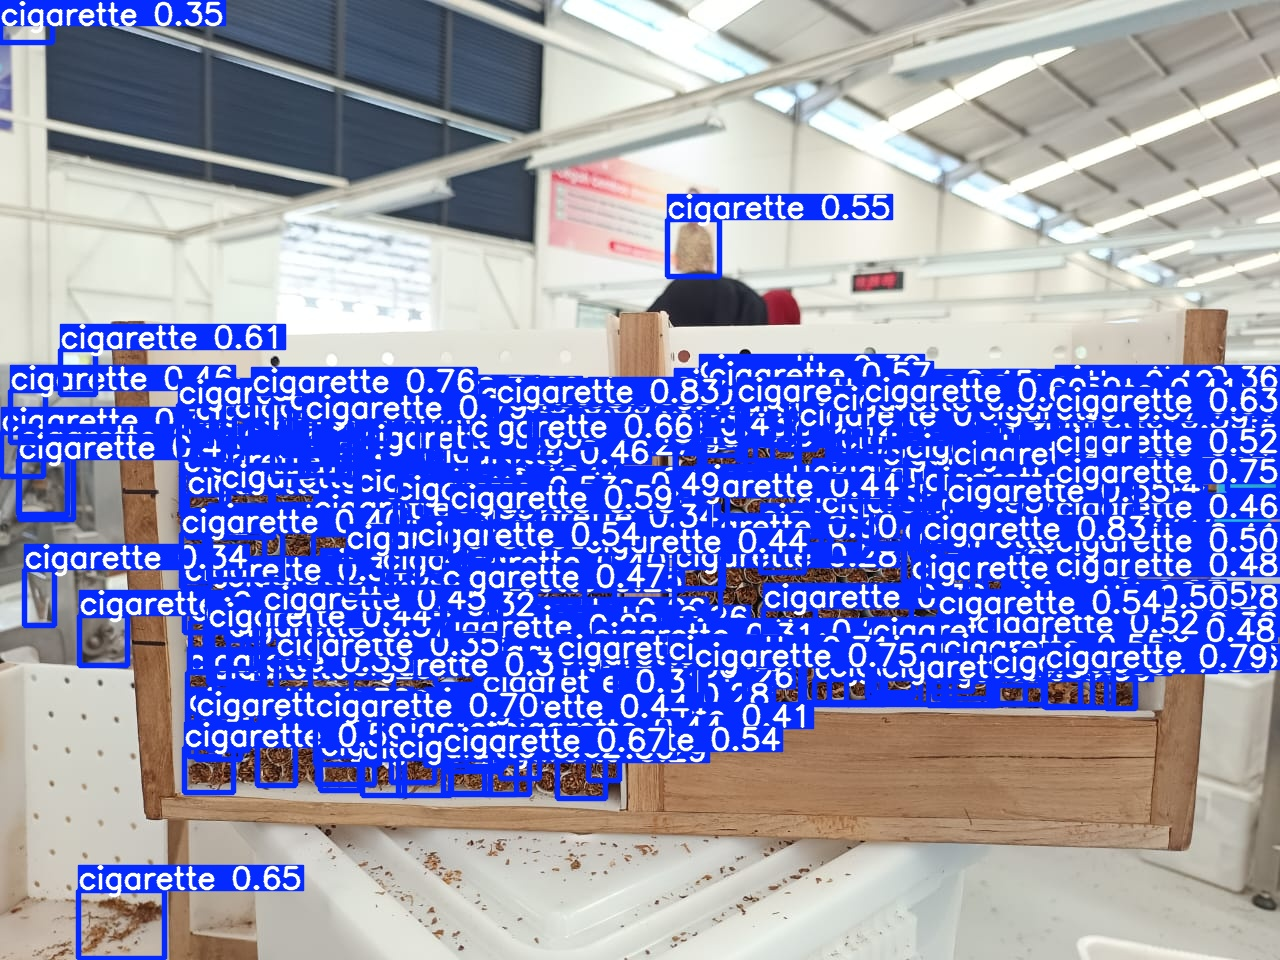

In [96]:
def check_predict_result(result):
    predict_result_path = result[0].save_dir
    predict_img = os.path.join(predict_result_path, os.listdir(predict_result_path)[0])

    return predict_img


Image(check_predict_result(results))

In [97]:
def check_count_detected_objects(results):
    num_detected_objects = len(results[0].boxes)
    print(f"Jumlah objek yang terdeteksi: {num_detected_objects}")

check_count_detected_objects(results)

Jumlah objek yang terdeteksi: 293


In [82]:
metrics = model.val(data='cigarettes.yaml')


def show_result_metric(metrics):
    print(f"Precision: {metrics.box.p}")
    print(f"Recall: {metrics.box.r}")
    print(f"mAP@0.5: {metrics.box.map50}")
    print(f"mAP@0.5:0.95: {metrics.box.map}")


show_result_metric(metrics)

Ultralytics 8.3.140 🚀 Python-3.12.9 torch-2.7.0+cu126 CPU (Intel Core(TM) i3-1005G1 1.20GHz)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 999.0±1212.4 MB/s, size: 122.4 KB)


val: Scanning /home/refanzzzz/PycharmProjects/cigarettes-yolo/data/labels/train.cache... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<?, ?it/s]
/home/refanzzzz/miniconda3/envs/cigarettes-yolo/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


                   all          5        214      0.994          1      0.995      0.755
Speed: 1.4ms preprocess, 119.3ms inference, 0.0ms loss, 6.4ms postprocess per image
Results saved to runs/detect/val
Precision: [    0.99404]
Recall: [          1]
mAP@0.5: 0.995
mAP@0.5:0.95: 0.7553829615795975


## **Testing 2**


image 1/1 /home/refanzzzz/PycharmProjects/cigarettes-yolo/data/testing/rokok-test-2.jpg: 448x640 15 cigarettes, 216.7ms
Speed: 2.5ms preprocess, 216.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict


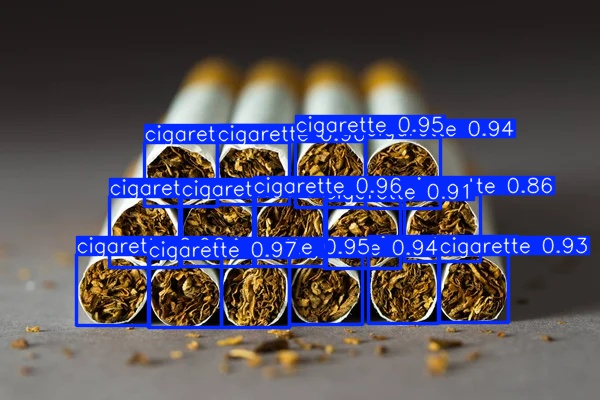

In [90]:
image_test = 'data/testing/rokok-test-2.jpg'
results_2 = model.predict(image_test, conf=0.5, save=True)

Image(check_predict_result(results_2))

In [91]:
check_count_detected_objects(results_2)

Jumlah objek yang terdeteksi: 15


## **Testing 3**


image 1/1 /home/refanzzzz/PycharmProjects/cigarettes-yolo/data/testing/rokok-test-3.jpg: 448x640 193 cigarettes, 357.0ms
Speed: 8.1ms preprocess, 357.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict3


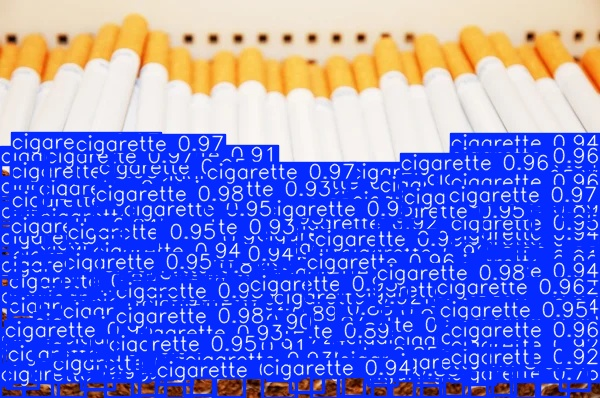

In [100]:
image_test = 'data/testing/rokok-test-3.jpg'
results_3 = model.predict(image_test, conf=0.5, save=True)

Image(check_predict_result(results_3))

In [101]:
check_count_detected_objects(results_3)

Jumlah objek yang terdeteksi: 193


## **Testing 4**


image 1/1 /home/refanzzzz/PycharmProjects/cigarettes-yolo/data/testing/rokok-test-4.jpg: 448x640 119 cigarettes, 132.8ms
Speed: 2.7ms preprocess, 132.8ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict3


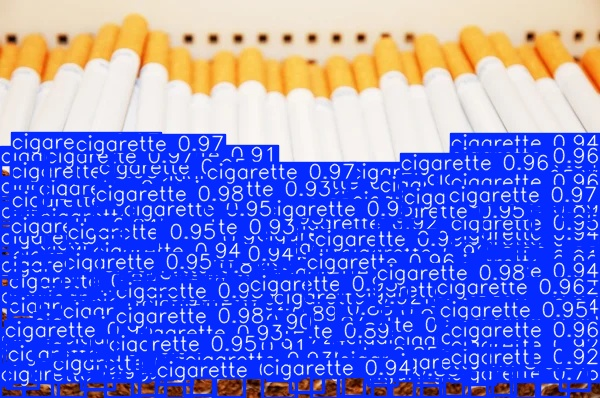

In [102]:
image_test = 'data/testing/rokok-test-4.jpg'
results_4 = model.predict(image_test, save=True)

Image(check_predict_result(results_4))

In [103]:
check_count_detected_objects(results_4)

Jumlah objek yang terdeteksi: 119
